## SVM V2 Classifier

🤓👆This script will do simple 2 classification task for L80 V2 data.  
It might be possible for other data sets, but detail need to be on discussion.
___

In [1]:
import Common_Functions as cf
from OI_Functions.Map_Subtractor import Sub_Map_Generator
from OI_Functions.VDaQ_dRR_Generator import BLK2DRR
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import cv2
import pandas as pd



wp = r'D:\ZR\_Data_Temp\VDaQ_Data\200910_L80_LM_OI'
# get run folder of G8 and RGLunm Run.
orien_folder = r'D:\ZR\_Data_Temp\VDaQ_Data\200910_L80_LM_OI\Run01_G8'
color_folder = r'D:\ZR\_Data_Temp\VDaQ_Data\200910_L80_LM_OI\Run12_RGLum4'



___
First, use standard data processor get dR/R Matrix, transfer data into python-readable data type.

In [2]:
orien_reader = BLK2DRR(orien_folder)
orien_reader.Read_All_Frames()
orien_reader.dR_R_Calculator(base_frame=[0,1],save=True)
color_reader = BLK2DRR(color_folder)
color_reader.Read_All_Frames()
color_reader.dR_R_Calculator(base_frame=[0,1],save=True)

___
Second, for this task, we need Orientation and Color Tunings. So A-O,H-V and RG-Lum graph is required for tuning calculation.  
*There will be better method for tuning estimation. But here we use the simplest one.(Use ttest maps)*

All Condition ID Names:dict_keys([-1, 1, 2, 3, 4, 5])
Folder D:\ZR\_Data_Temp\VDaQ_Data\200910_L80_LM_OI\_V2_Sripe_Method already exists!
All Condition ID Names:dict_keys([-1, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Folder D:\ZR\_Data_Temp\VDaQ_Data\200910_L80_LM_OI\_V2_Sripe_Method already exists!
Folder D:\ZR\_Data_Temp\VDaQ_Data\200910_L80_LM_OI\_V2_Sripe_Method already exists!


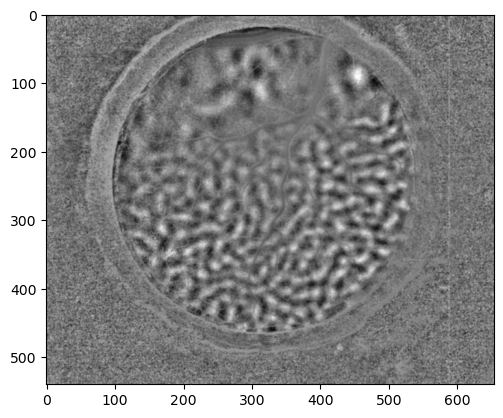

In [5]:
color_drr = cf.Load_Variable(r'D:\ZR\_Data_Temp\VDaQ_Data\200910_L80_LM_OI\Run12_RGLum4\Processed\dRR_Dictionaries.pkl')
calculator = Sub_Map_Generator(color_drr)
rglum,rg_raw_drr,rg_filted_drr,p_rg = calculator.Get_Map([1,2],[3,4],clip_value = 5,savepath = r'D:\ZR\_Data_Temp\VDaQ_Data\200910_L80_LM_OI\_V2_Sripe_Method',filter_flag=True,HP_sigma=20,LP_sigma=0.75,graph_name = 'RG-Lum')
# sns.heatmap(flited_drr,center = flited_drr.mean(),square = True) # Q-check

## then AO and HV
orein_drr = cf.Load_Variable(r'D:\ZR\_Data_Temp\VDaQ_Data\200910_L80_LM_OI\Run01_G8\Processed\dRR_Dictionaries.pkl')
calculator = Sub_Map_Generator(orein_drr)
ao,ao_raw_drr,ao_filted_drr,p_ao = calculator.Get_Map([2,6],[4,8],clip_value = 5,savepath = r'D:\ZR\_Data_Temp\VDaQ_Data\200910_L80_LM_OI\_V2_Sripe_Method',filter_flag=True,HP_sigma=20,LP_sigma=0.75,graph_name = 'A-O')
# sns.heatmap(flited_drr,center = flited_drr.mean(),square = True)

hv,hv_raw_drr,hv_filted_drr,p_hv = calculator.Get_Map([1,5],[3,7],clip_value = 5,savepath = r'D:\ZR\_Data_Temp\VDaQ_Data\200910_L80_LM_OI\_V2_Sripe_Method',filter_flag=True,HP_sigma=20,LP_sigma=0.75,graph_name = 'H-V')
# sns.heatmap(flited_drr,center = flited_drr.mean(),square = True)

🤓👆**Attention the difference and effect of filter. Graph after and before filt can be very different on absolute value.**   

Text(0.5, 1.0, 'HP Filted H-V')

<Figure size 640x480 with 0 Axes>

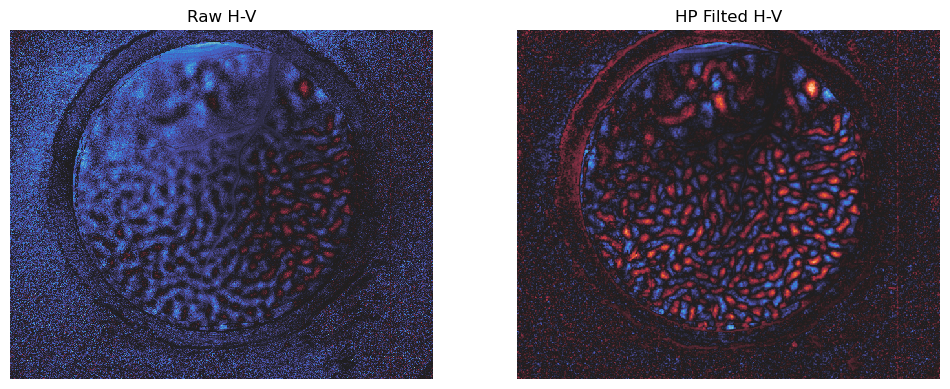

In [16]:
# use hv graph as an example.
plt.clf()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,7))
sns.heatmap(hv_raw_drr,center = 0,square = True,ax = ax[0],xticklabels=False,yticklabels=False,cbar = False)
sns.heatmap(hv_filted_drr,center = 0,square = True,ax = ax[1],xticklabels=False,yticklabels=False,cbar = False)
# center = 0, as filted graph to be 0.
ax[0].set_title('Raw H-V')
ax[1].set_title('HP Filted H-V')


___
##### Step 3, we will use these 3 graph to generate orientation and color tuning.   
***We Reprocess graphs with parameters more clearly***   
Plot tuning by location. This part can be surely refined.   
Use clip and normalize to get standarized tuning, so this might be useful for other data sets.

In [18]:
# load in raw graphs, and filt raw graph with parameters we want.
# clip and normalize graph, to get tunings of orientation and color.
from scipy.ndimage import gaussian_filter

wp = r'D:\ZR\_Data_Temp\VDaQ_Data\200910_L80_LM_OI\_V2_Sripe_Method'
LP_sigma = 0.75
HP_sigma = 20
clip_std = 2.5
hv_raw = cf.Load_Variable(wp,'H-V_Raw.pkl')
ao_raw = cf.Load_Variable(wp,'A-O_Raw.pkl')
rg_raw = cf.Load_Variable(wp,'RG-Lum_Raw.pkl')
filted_graph = []# save 3 graph into this list

for i,c_map in tqdm(enumerate([hv_raw,ao_raw,rg_raw])):
    c_clipped = np.clip(c_map,c_map.mean()-clip_std*c_map.std(),c_map.mean()+clip_std*c_map.std()) # clip with std given
    HP_graph = gaussian_filter(input = c_clipped, sigma = HP_sigma)
    LP_graph = gaussian_filter(input = c_clipped, sigma = LP_sigma)
    c_filted_graph = (LP_graph-HP_graph) # filt after clip
    filted_graph.append(c_filted_graph)

tunings = np.array(filted_graph)
orien_tunings = abs(tunings[:2,:,:]).max(0) # Use HV and AO's best tuning
color_tunings = abs(tunings[2,:,:]) # use RGLum to get best color tuning.

# normalize tunings of Orientation and Color into 0-1 range.
orien_tunings = orien_tunings/orien_tunings.max()
color_tunings = color_tunings/color_tunings.max()
tuning_array = np.array([orien_tunings,color_tunings]) 
cf.Save_Variable(wp,'tunings',tuning_array) # save variable.

tuning_array.shape # this var is tuning*pix

0it [00:00, ?it/s]

3it [00:00,  9.26it/s]


(2, 540, 654)

Text(0.5, 1.0, 'Color Tunings')

<Figure size 640x480 with 0 Axes>

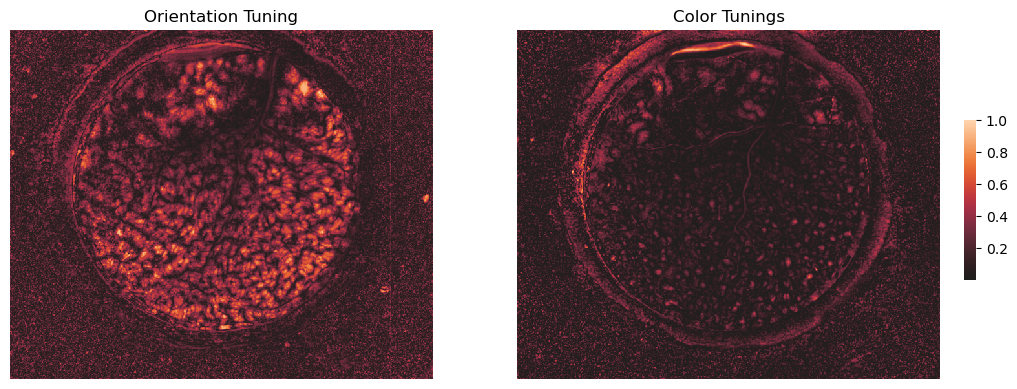

In [27]:
## Let's see the tunings. Range between 0-1

plt.clf()
label_size = 14
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
cbar_ax = fig.add_axes([0.92, .4, .01, .2])

sns.heatmap(tuning_array[0,:,:],center = 0,square = True,ax = ax[0],xticklabels=False,yticklabels=False,cbar_ax= cbar_ax)
sns.heatmap(tuning_array[1,:,:],center = 0,square = True,ax = ax[1],xticklabels=False,yticklabels=False,cbar_ax= cbar_ax)

cbar_ax.yaxis.label.set_size(label_size)

ax[0].set_title('Orientation Tuning')
ax[1].set_title('Color Tunings')

___
#### Step 4, Get Training set.   
Load in masks we manually generated by GIMP, and get thin and thick data sets.



Text(0.5, 1.0, 'V2 Mask')

<Figure size 640x480 with 0 Axes>

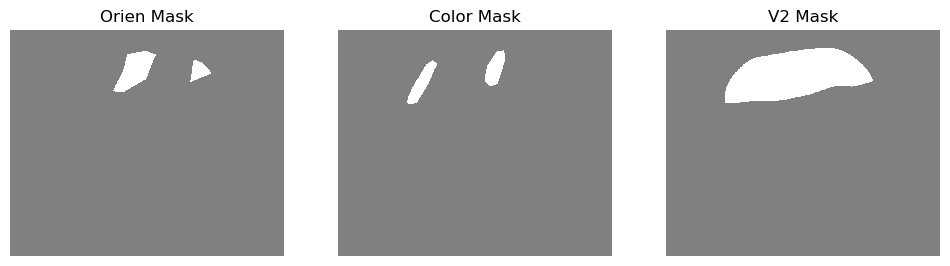

In [31]:
# load thick and thin domain's mask
mask_path = r'D:\ZR\_Data_Temp\VDaQ_Data\200910_L80_LM_OI\_V2_Sripe_Method\Masks'

thick_mask = cv2.imread(cf.join(mask_path,'orien_mask.png'),0)>128
thin_mask = cv2.imread(cf.join(mask_path,'colormask.png'),0)>128
v2_mask = cv2.imread(cf.join(mask_path,'V2_Mask.png'),0)>128


plt.clf()
label_size = 14
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,7))
sns.heatmap(thick_mask,center = 0,square = True,ax = ax[0],xticklabels=False,yticklabels=False,cbar=False,cmap = 'gray')
sns.heatmap(thin_mask,center = 0,square = True,ax = ax[1],xticklabels=False,yticklabels=False,cbar=False,cmap = 'gray')
sns.heatmap(v2_mask,center = 0,square = True,ax = ax[2],xticklabels=False,yticklabels=False,cbar=False,cmap = 'gray')

ax[0].set_title('Orien Mask')
ax[1].set_title('Color Mask')
ax[2].set_title('V2 Mask')

Get train set of thin and thick from tunings.   
Set thin stripe as 1, and thick stripe as 2.   


In [35]:
# get train sets
thick_tunings = tuning_array[:,thick_mask] # thick mask's tunings
thin_tunings = tuning_array[:,thin_mask] # thin mask's tuning
train_sets = np.concatenate((thick_tunings,thin_tunings),axis = 1) 
train_sets = train_sets.T # data sets of training tunings
# get train ids
thick_ids = np.ones(thick_tunings.shape[1])*1
thin_ids = np.ones(thin_tunings.shape[1])*2
train_ids = np.concatenate((thick_ids,thin_ids)) # ids of training data sets.

# plot train set's tuning ID and it's tuning location.
plotable = pd.DataFrame(0.0,index = range(len(train_ids)),columns = ['Orien_Tuning','Color_Tuning','Stripe'])
for i in tqdm(range(len(train_ids))):
    c_id = ['Error','Thick','Thin'][int(train_ids[i])]
    plotable.loc[i,:] = [train_sets[i,0],train_sets[i,1],c_id]


plotable # this is our train set.

100%|██████████| 12591/12591 [00:04<00:00, 2804.45it/s]


,Orien_Tuning,Color_Tuning,Stripe
0,0.539944,0.249087,Thick
1,0.613395,0.217015,Thick
2,0.696349,0.216977,Thick
3,0.678151,0.225637,Thick
4,0.647456,0.240856,Thick
...,...,...,...
12586,0.347118,0.112721,Thin
12587,0.438996,0.111772,Thin
12588,0.520295,0.172798,Thin
12589,0.487639,0.172088,Thin


Plot tuning of all training data sets.   
You might try scatter and histplot, but the seperator might not be easy to recognize.   
🤓👆So we use kde estimator!

<AxesSubplot: xlabel='Orien_Tuning', ylabel='Color_Tuning'>

<Figure size 640x480 with 0 Axes>

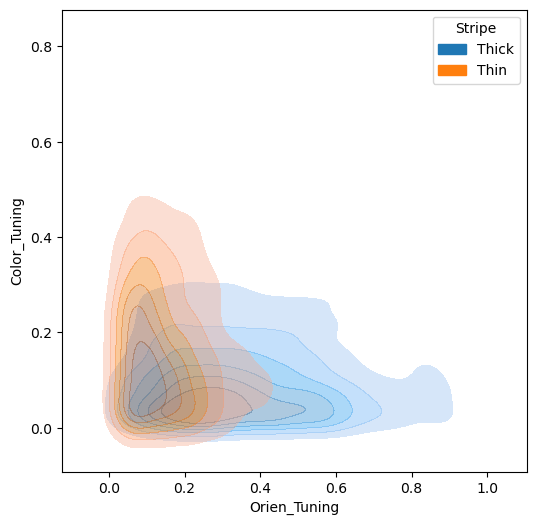

In [37]:

# plt.clf()
plt.cla()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
# sns.scatterplot(data = plotable,x = 'Orien_Tuning',y = 'Color_Tuning',hue = 'Stripe',ax = ax,s = 5,linewidth=0,alpha = 0.5)
# sns.histplot(data = plotable,x = 'Orien_Tuning',y = 'Color_Tuning',hue = 'Stripe',ax = ax,alpha = 0.4, palette="tab10",bins = 25)
sns.kdeplot(data = plotable,x = 'Orien_Tuning',y = 'Color_Tuning',hue = 'Stripe',ax = ax,alpha = 0.4, palette="tab10",fill=True,levels = 7,thresh=0.1)


___
#### Step 5, train SVM.  
Plot svm test dataset and determine function.  
Unlinear svm might work better, and paras can be refined too.   
Linear works fairly good.  

In [38]:
# we use linear kernal svm and prob. model.
from sklearn import svm
from sklearn.model_selection import cross_val_score

# fit svm, and test 5-fold score validation.
classifier = svm.SVC(C = 1,probability=True,kernel='linear') # probability=True can return a prob. of classify into a class.
scores = cross_val_score(classifier,train_sets, list(train_ids), cv=5)
print(f'Score of 5 fold SVC on unsupervised : {scores.mean()*100:.2f}%')
classifier.fit(train_sets,list(train_ids))



Score of 5 fold SVC on unsupervised : 76.85%


SVC(C=1, kernel='linear', probability=True)

___
Step 6, Use this classifier to classify all V2 data.   
Let's see how this classifier works.

In [39]:
v2_datas = tuning_array[:,v2_mask]
test_data = v2_datas.reshape(2,-1).T # reshape data in N_sample*N_dims,here is Nx2
pred_ids = classifier.predict(test_data)# svm-predicted id of all V2 classification
pred_probs = classifier.predict_proba(test_data)# probability of classification of 2 class
dists = classifier.decision_function(test_data)# distance of each point toward determine function

# we can also get determin function if you need. y = k*x +b
w = classifier.coef_[0]
k = -w[0] / w[1]
b = -classifier.intercept_[0]/ w[1]

# save train data in dataframe.
test_dataframe = pd.DataFrame(0.0,index = range(len(test_data)),columns = ['Orien_Tuning','Color_Tuning','Predicted_id','Thick_Prob','Thin_Prob','Dists'])

for i in tqdm(range(len(test_data))):
    c_id = ['Error','Thick','Thin'][int(pred_ids[i])]
    test_dataframe.loc[i,:] = [test_data[i,0],test_data[i,1],c_id,pred_probs[i,0],pred_probs[i,1],dists[i]]
cf.Save_Variable(wp,'Predicted_V2_ID_Linear',test_dataframe)
cf.Save_Variable(wp,'SVM_Model',classifier)
test_dataframe

100%|██████████| 31671/31671 [00:32<00:00, 962.16it/s]


,Orien_Tuning,Color_Tuning,Predicted_id,Thick_Prob,Thin_Prob,Dists
0,0.212484,0.113931,Thick,0.534793,0.465207,-0.081205
1,0.165966,0.128047,Thin,0.405002,0.594998,0.346818
2,0.122610,0.120973,Thin,0.314912,0.685088,0.671626
3,0.106667,0.078736,Thin,0.321726,0.678274,0.645836
4,0.088226,0.048274,Thin,0.311826,0.688174,0.683403
...,...,...,...,...,...,...
31666,0.141815,0.121679,Thin,0.352587,0.647413,0.518852
31667,0.073869,0.098094,Thin,0.239518,0.760482,0.982081
31668,0.166291,0.108058,Thin,0.427926,0.572074,0.270947
31669,0.295029,0.074120,Thick,0.755865,0.244135,-0.894814


Quality Check, let's see the training data point.

<AxesSubplot: xlabel='Orien_Tuning', ylabel='Color_Tuning'>

<Figure size 640x480 with 0 Axes>

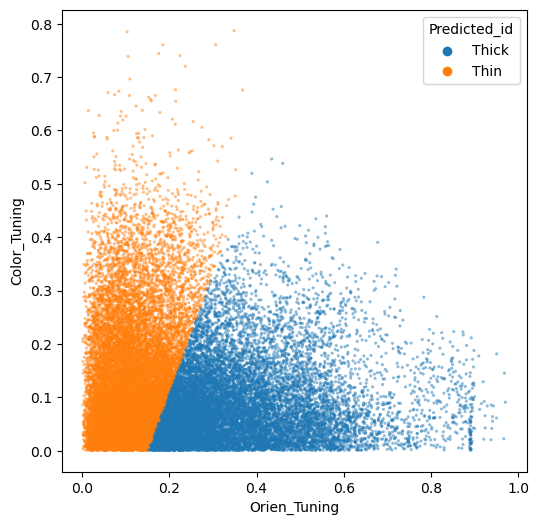

In [41]:
plt.clf()
# plt.cla()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
sns.scatterplot(data = test_dataframe,x = 'Orien_Tuning',y = 'Color_Tuning',hue = 'Predicted_id',ax = ax,s = 5,linewidth=0,alpha = 0.5)

Well, it seems sucks(Maybe kde will see the difference better)   
But be careful! We might still be right.   
Plot predicted probability, distance, and classifier id.

Text(0.5, 1.0, 'SVM Distance')

<Figure size 640x480 with 0 Axes>

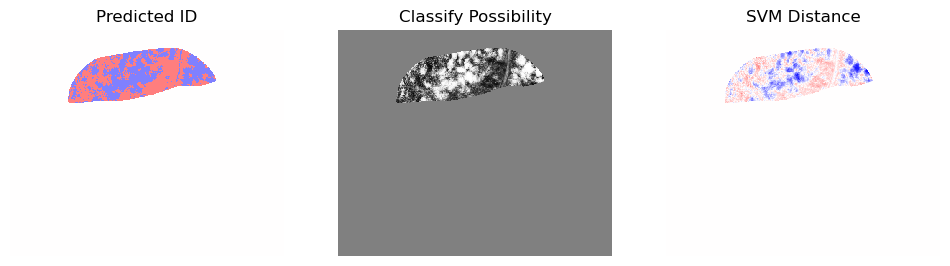

In [63]:
# Predicted ID
recovered_data_class = np.zeros(shape = (540,654))+1.5
recovered_data_class[v2_mask == 1] = pred_ids

# Recovered Prob.
recovered_data_prob = np.zeros(shape = (540,654))+0.5
recovered_data_prob[v2_mask == 1] = pred_probs[:,0]

# Distance toward decision plane
recovered_data_dist = np.zeros(shape = (540,654))
recovered_data_dist[v2_mask == 1] = dists


plt.clf()
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,6))
# cbar_ax = fig.add_axes([0.92, .4, .01, .2])


sns.heatmap(recovered_data_class,vmax = 2.5,vmin = 0.5,center = 1.5,xticklabels=False,yticklabels=False,square=True,ax = ax[0],cbar=False,cmap='bwr')
sns.heatmap(recovered_data_prob,vmax = 1,vmin = 0,center = 0.5,xticklabels=False,yticklabels=False,cmap = 'gray',square=True,ax = ax[1],cbar=False)
sns.heatmap(recovered_data_dist,center = 0,xticklabels=False,yticklabels=False,square=True,ax = ax[2],cmap='bwr',cbar = False)

ax[0].set_title('Predicted ID')
ax[1].set_title('Classify Possibility')
ax[2].set_title('SVM Distance')
